In [1]:
!pip install prophet  # Uncomment this line if Prophet is not already installed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# For illustration, let's assume your file is simply named 'legal_consultations.csv'
df = pd.read_csv('/content/consultation.csv')
df

,date,completed,system_canceled,client_canceled,order_expired,lawyer_miscall,order_cancelled,total_case_generated,completion_percentage
0,9/19/2024,7,10,1,45,0,0,63,11.11
1,9/20/2024,10,1,1,47,0,0,59,16.95
2,9/21/2024,6,4,0,12,0,0,22,27.27
3,9/22/2024,7,1,0,33,0,0,41,17.07
4,9/23/2024,9,0,1,16,0,0,26,34.62
...,...,...,...,...,...,...,...,...,...
99,12/27/2024,4,3,0,2,0,4,13,30.77
100,12/28/2024,5,5,0,3,0,3,16,31.25
101,12/29/2024,2,0,0,1,0,0,3,66.67
102,12/30/2024,6,1,0,2,0,1,10,60.00


In [4]:
holidays_df = pd.DataFrame({
    'holiday': 'public_holiday',
    'ds': pd.to_datetime(['2024-12-25', '2025-01-01']),  # add relevant dates
    'lower_window': 0,
    'upper_window': 0
})
holidays_df

,holiday,ds,lower_window,upper_window
0,public_holiday,2024-12-25,0,0
1,public_holiday,2025-01-01,0,0


In [5]:
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort by date just in case
df.sort_values(by='date', inplace=True)

# Optionally, fill any missing values (depending on your data specifics)
# For example, if we assume 0 for missing numerical columns:
df.fillna(0, inplace=True)

In [6]:
df_prophet = df[['date', 'completed']].rename(columns={
    'date': 'ds',
    'completed': 'y'
})

In [7]:
model = Prophet(
    interval_width=0.90,                # default = 90%, can tune
    holidays=holidays_df,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,            # turn off daily if not relevant
    changepoint_prior_scale=0.1,        # default = 0.05, try different values
    seasonality_prior_scale=10.0        # default = 10, can tune
)
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy9k1of2/3520n97x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy9k1of2/txy4_6c4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25333', 'data', 'file=/tmp/tmpfy9k1of2/3520n97x.json', 'init=/tmp/tmpfy9k1of2/txy4_6c4.json', 'output', 'file=/tmp/tmpfy9k1of2/prophet_modellkvmb1kn/prophet_model-20250108154703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:47:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [8]:
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 3, 31)
forecast_days = (end_date - df_prophet['ds'].max()).days

# However, to be safe, let's just specify the horizon we want:
future_df = model.make_future_dataframe(
    periods=90,  # ~ 3 months
    freq='D'
)

In [9]:
future_df = future_df[future_df['ds'] <= end_date]

In [10]:
forecast = model.predict(future_df)

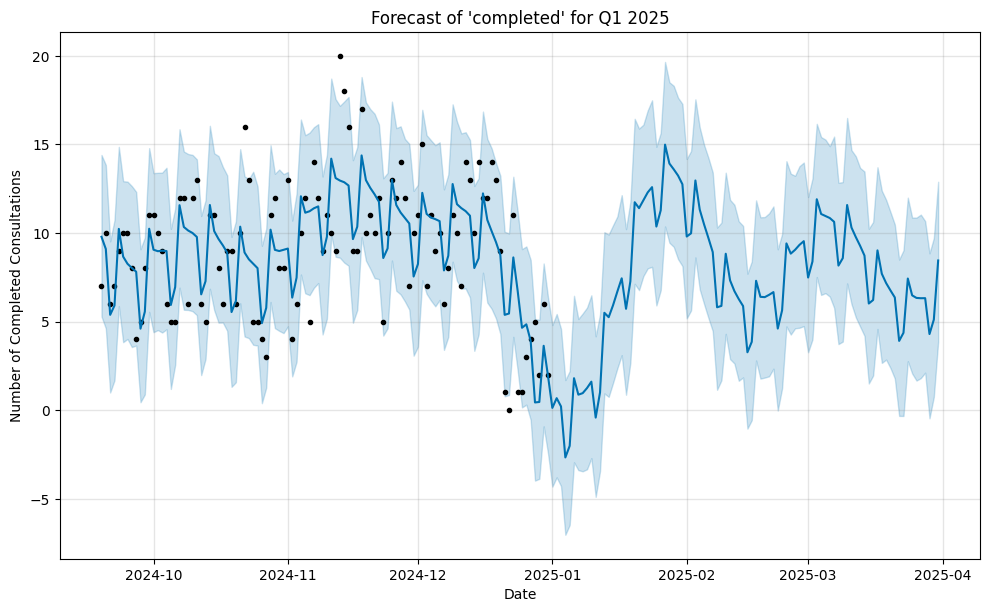

In [11]:
fig1 = model.plot(forecast)
plt.title("Forecast of 'completed' for Q1 2025")
plt.xlabel("Date")
plt.ylabel("Number of Completed Consultations")
plt.show()

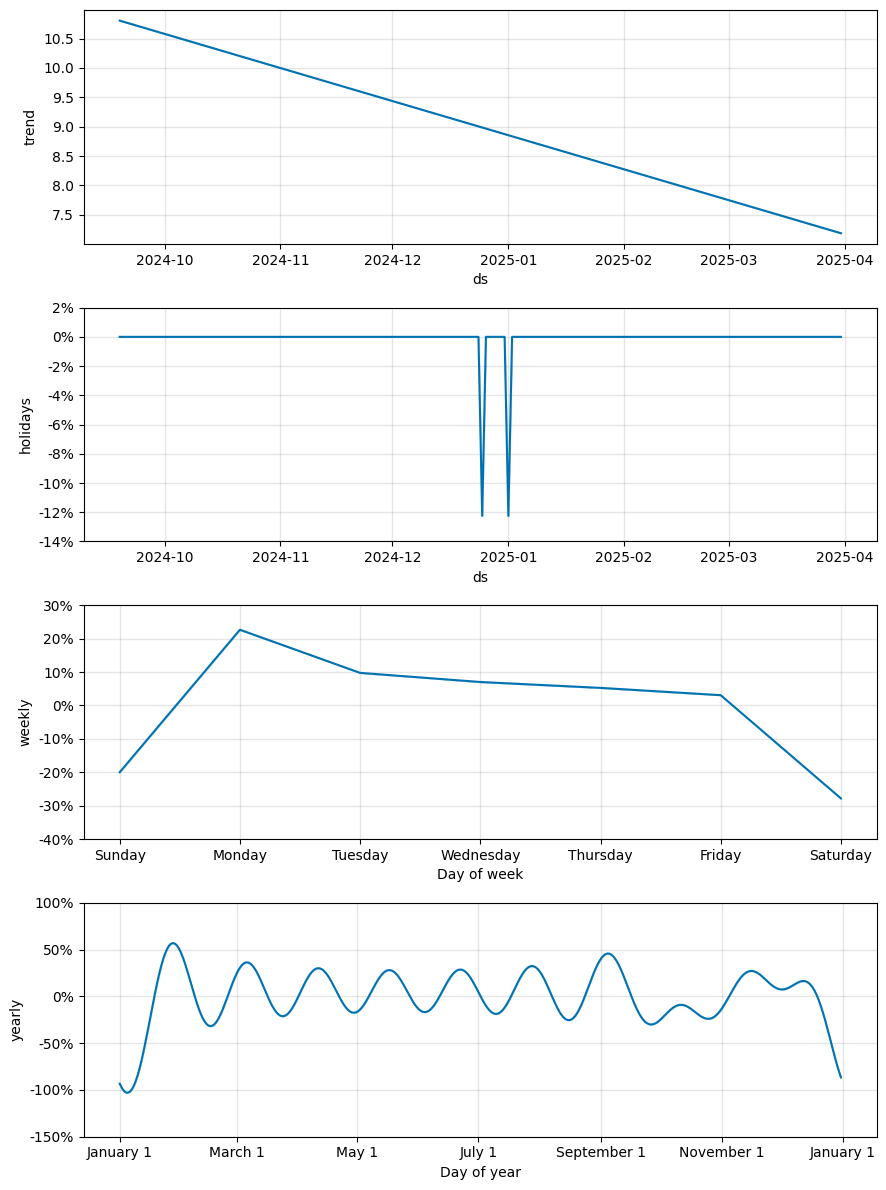

In [12]:
# Optionally, view forecast components
fig2 = model.plot_components(forecast)
plt.show()

In [13]:
print("Forecast for Q1 2025 (Jan 1 to Mar 31):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

Forecast for Q1 2025 (Jan 1 to Mar 31):
            ds       yhat  yhat_lower  yhat_upper
0   2024-09-19   9.788475    5.292990   14.408318
1   2024-09-20   9.099285    4.616292   13.845238
2   2024-09-21   5.382076    0.996745    9.531150
3   2024-09-22   5.908083    1.686078   10.727282
4   2024-09-23  10.235621    5.873363   14.866659
..         ...        ...         ...         ...
189 2025-03-27   6.320070    1.808528   11.040699
190 2025-03-28   6.323297    2.114778   10.675424
191 2025-03-29   4.296961   -0.461743    8.854434
192 2025-03-30   5.110727    0.751788    9.718798
193 2025-03-31   8.451116    3.861037   12.896010

[194 rows x 4 columns]


In [22]:
forecast.to_csv('consultation_forecast.csv', index=False)

In [14]:
df_prophet = df[['date', 'completed']].copy()
df_prophet.columns = ['ds', 'y']

In [15]:
cutoff_date = '2024-12-15'  # adjust as needed

train_df = df_prophet[df_prophet['ds'] <= cutoff_date].copy()
valid_df = df_prophet[df_prophet['ds'] > cutoff_date].copy()

print("Training set range:", train_df['ds'].min(), "to", train_df['ds'].max())
print("Validation set range:", valid_df['ds'].min(), "to", valid_df['ds'].max())
print("Training set size:", len(train_df))
print("Validation set size:", len(valid_df))

Training set range: 2024-09-19 00:00:00 to 2024-12-15 00:00:00
Validation set range: 2024-12-16 00:00:00 to 2024-12-31 00:00:00
Training set size: 88
Validation set size: 16


In [16]:
model = Prophet(interval_width=0.90)
model.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy9k1of2/lslj6vbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy9k1of2/iq8tthr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69694', 'data', 'file=/tmp/tmpfy9k1of2/lslj6vbg.json', 'init=/tmp/tmpfy9k1of2/iq8tthr5.json', 'output', 'file=/tmp/tmpfy9k1of2/prophet_modelm2cc1jva/prophet_model-20250108154705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:47:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
periods = len(valid_df)
future_valid = model.make_future_dataframe(periods=periods, freq='D')

In [18]:
max_valid_date = valid_df['ds'].max()
future_valid = future_valid[future_valid['ds'] <= max_valid_date]

forecast_valid = model.predict(future_valid)

In [19]:
merged = pd.merge(valid_df, forecast_valid[['ds', 'yhat']], on='ds', how='left')

In [20]:
mae = mean_absolute_error(merged['y'], merged['yhat'])
mse = mean_squared_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((merged['y'] - merged['yhat']) / merged['y'])) * 100

print(f"Validation MAE:  {mae:.2f}")
print(f"Validation MSE:  {mse:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAPE: {mape:.2f}%")

Validation MAE:  6.46
Validation MSE:  57.79
Validation RMSE: 7.60
Validation MAPE: inf%


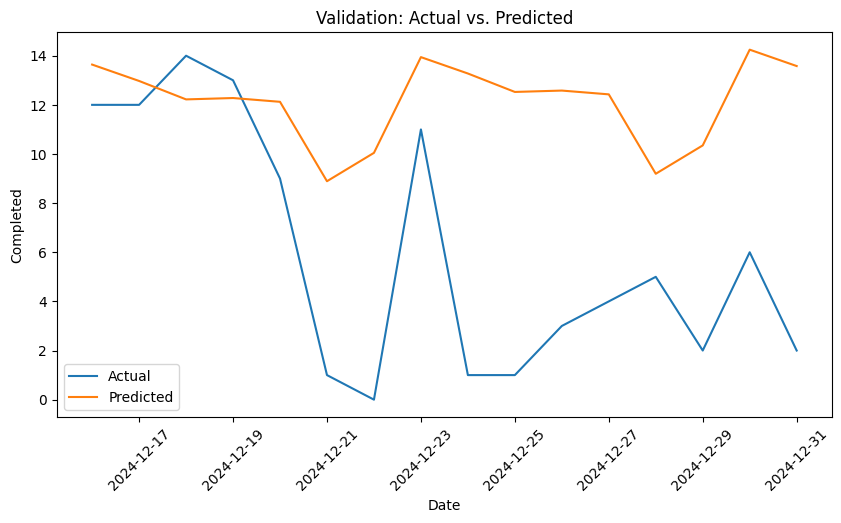

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(merged['ds'], merged['y'], label='Actual')
plt.plot(merged['ds'], merged['yhat'], label='Predicted')
plt.legend()
plt.title('Validation: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Completed')
plt.xticks(rotation=45)
plt.show()

**CLIENT SIGN-UP**

In [25]:
df = pd.read_csv('/content/client-signup.csv')  # Update with your actual filename/path

In [26]:
# Make sure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort by date just in case
df.sort_values(by='date', inplace=True)

# Optionally, fill any missing values (depending on your data specifics)
# For example, if we assume 0 for missing numerical columns:
df.fillna(0, inplace=True)

In [27]:
df_prophet = df[['date', 'total_created_clients']].rename(columns={
    'date': 'ds',
    'total_created_clients': 'y'
})

In [28]:
model = Prophet(
    interval_width=0.90,                # default = 90%, can tune
    holidays=holidays_df,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,            # turn off daily if not relevant
    changepoint_prior_scale=0.1,        # default = 0.05, try different values
    seasonality_prior_scale=10.0        # default = 10, can tune
)
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy9k1of2/hdk9hcl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfy9k1of2/56iscse5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22674', 'data', 'file=/tmp/tmpfy9k1of2/hdk9hcl4.json', 'init=/tmp/tmpfy9k1of2/56iscse5.json', 'output', 'file=/tmp/tmpfy9k1of2/prophet_modelbtv5aklz/prophet_model-20250108155919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 3, 31)
forecast_days = (end_date - df_prophet['ds'].max()).days

# However, to be safe, let's just specify the horizon we want:
future_df = model.make_future_dataframe(
    periods=90,  # ~ 3 months
    freq='D'
)

In [30]:
future_df = future_df[future_df['ds'] <= end_date]

In [31]:
forecast = model.predict(future_df)

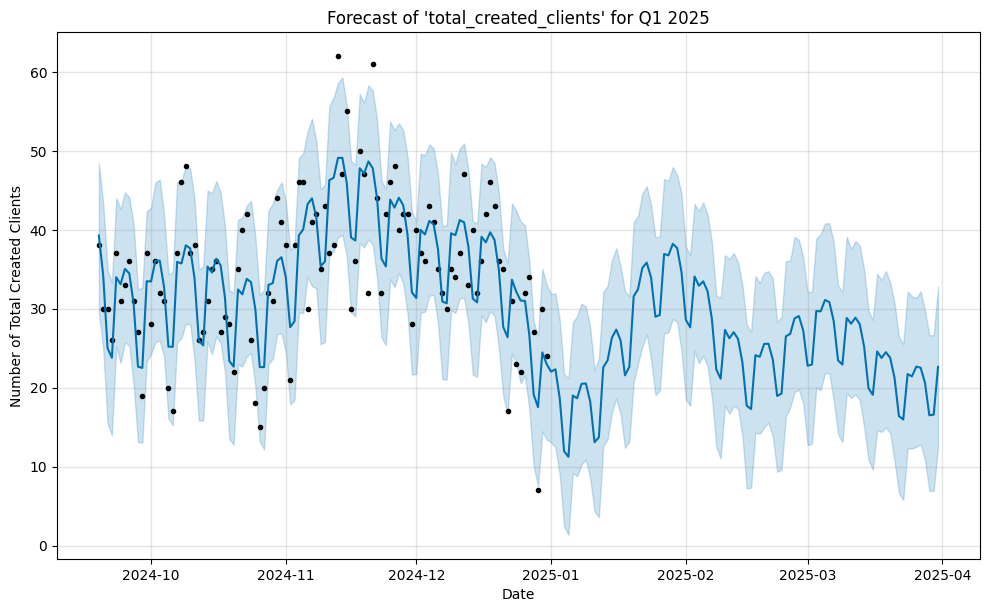

In [32]:
fig1 = model.plot(forecast)
plt.title("Forecast of 'total_created_clients' for Q1 2025")
plt.xlabel("Date")
plt.ylabel("Number of Total Created Clients")
plt.show()

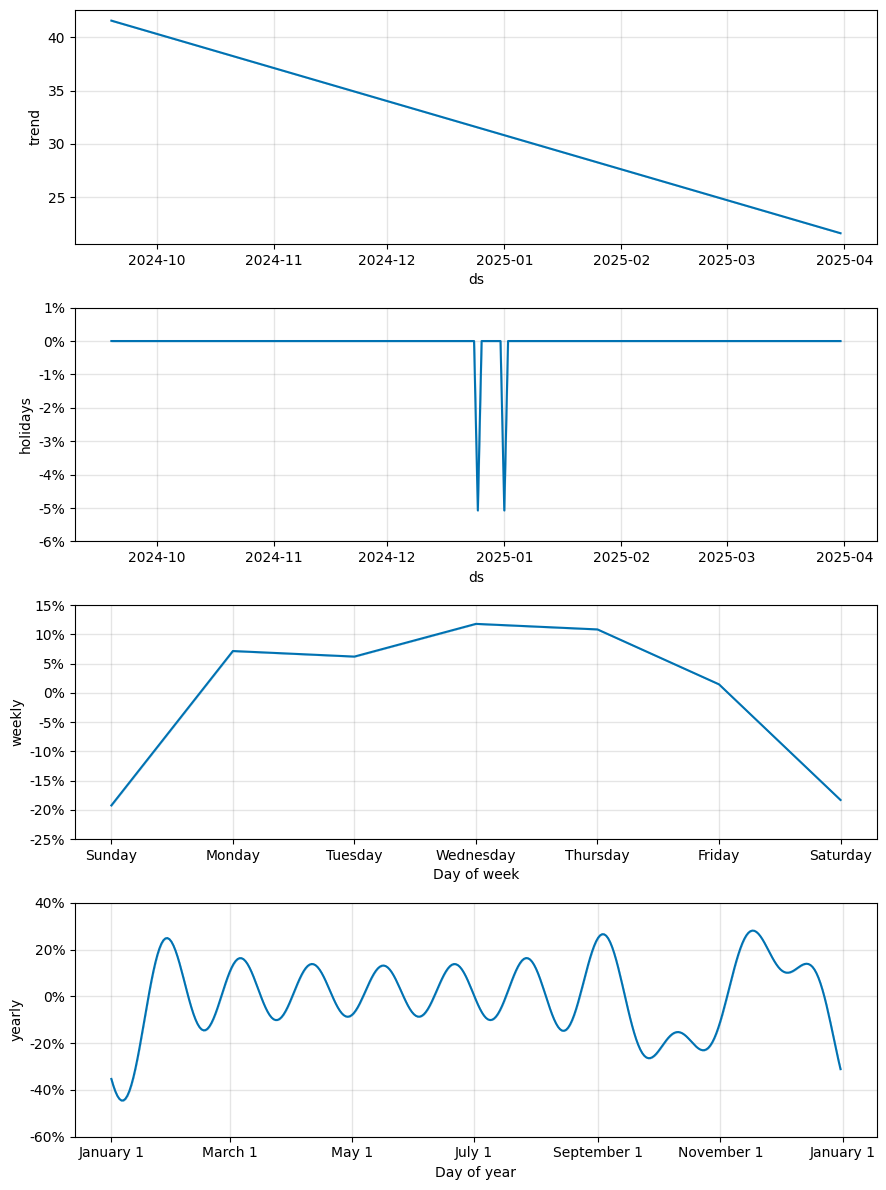

In [33]:
# Optionally, view forecast components
fig2 = model.plot_components(forecast)
plt.show()

In [34]:
print("Forecast for Q1 2025 (Jan 1 to Mar 31):")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

Forecast for Q1 2025 (Jan 1 to Mar 31):
            ds       yhat  yhat_lower  yhat_upper
0   2024-09-19  39.255393   29.660042   48.353154
1   2024-09-20  34.182507   24.898593   43.364306
2   2024-09-21  24.991998   15.531419   34.893125
3   2024-09-22  23.781874   13.930626   33.332387
4   2024-09-23  33.988659   25.250694   44.017455
..         ...        ...         ...         ...
189 2025-03-27  22.519315   12.802031   32.178811
190 2025-03-28  20.600326   10.811443   29.750916
191 2025-03-29  16.491813    6.904984   26.614603
192 2025-03-30  16.578340    6.925838   26.657852
193 2025-03-31  22.627185   12.498060   32.792949

[194 rows x 4 columns]


In [35]:
forecast.to_csv('client_signup_forecast.csv', index=False)